# Export DeepSeek Images  - Absorbed Weights

Can I go naive the whole way? That would simplify things a lot

In [1]:
from transformers import AutoTokenizer
import torch

import sys
sys.path.append('DeepSeek-V3/inference') #Github slightly newer, I made some source code modification for datatype
# sys.path.append('DeepSeek-V3/DeepSeek-V3/inference') #Hugging face

from model import Transformer, MLA, ModelArgs, apply_rotary_emb
import matplotlib.pyplot as plt

from safetensors.torch import load_model, load_file
import os
from tqdm import tqdm
import shutil

In [2]:
save_dir='deepseek_viz_absorbed_1'

# if os.path.exists(save_dir):
#     shutil.rmtree(save_dir)
# os.makedirs(save_dir)

In [3]:
args=ModelArgs(**{"vocab_size": 129280,
                "dim": 7168,
                "inter_dim": 18432,
                "moe_inter_dim": 2048,
                "n_layers": 61,
                "n_dense_layers": 3,
                "n_heads": 128,
                "n_routed_experts": 256,
                "n_shared_experts": 1,
                "n_activated_experts": 8,
                "n_expert_groups": 8,
                "n_limited_groups": 4,
                "route_scale": 2.5,
                "score_func": "sigmoid",
                "q_lora_rank": 1536,
                "kv_lora_rank": 512,
                "qk_nope_head_dim": 128,
                "qk_rope_head_dim": 64,
                "v_head_dim": 128,
                "dtype": "bf16"}) #fp8 seems out due to my hardware? bf16

In [4]:
model=Transformer(args)

In [5]:
# ckpt_path='/home/stephen/deepseek/DeepSeek-V3/DeepSeek-V3'
ckpt_path='/home/stephen/deepseek/clean_hf_pull/DeepSeek-V3/weights_converted'
# ckpt_path='/home/stephen/deepseek/clean_hf_pull/DeepSeek-V3/weights_converted_2' ##Not enough RAM to load this puppy, could try a middle ground
# rank=0
# world_size=1

#
# missing, unexpected=load_model(model, os.path.join(ckpt_path, 'model-00001-of-000163.safetensors'), strict=False)
# load_model(model, os.path.join(ckpt_path, 'model-00009-of-000163.safetensors'), strict=False)
# missing, unexpected=load_model(model, os.path.join(ckpt_path, "model0-mp1.safetensors"), strict=False) #Result of conversion process

state_dict = load_file(os.path.join(ckpt_path, "model0-mp1.safetensors"), device='cpu')
model_state_dict=model.state_dict()

In [6]:
missing, unexpected = model.load_state_dict(state_dict, strict=False)

In [7]:
len(state_dict), len(missing), len(unexpected)

(846, 44960, 411)

In [8]:
model.layers[0].attn.wq_a.weight.detach().abs().sum() #Not zero bro

tensor(7.5078e+08, dtype=torch.bfloat16)

In [9]:
model.embed.weight.detach().abs().sum()

tensor(27375474.)

In [10]:
tokenizer = AutoTokenizer.from_pretrained('/home/stephen/deepseek/DeepSeek-V3/DeepSeek-V3')

In [11]:
# tokens=tokenizer.encode("The American flag is red, white, and")
tokens=tokenizer.encode("The American flag is red, white, and blue")

In [12]:
logits=model.forward(torch.tensor([tokens]), start_pos=0) #Dope! Ran on CPU somehow - took a couple minutes. 

In [13]:
tokens

[0, 671, 3707, 14364, 344, 4332, 14, 5403, 14, 305, 8295]

### Setup for Forward Pass

In [14]:
start_pos=0 #might need to noodle with this to understad caching
seqlen = torch.tensor([tokens]).size(1)
freqs_cis = model.freqs_cis[start_pos:start_pos+seqlen]

mask = None
if seqlen > 1:
    mask = torch.full((seqlen, seqlen), float("-inf"), device='cpu').triu_(1) #CPUing for now

start_pos, seqlen, freqs_cis.shape, mask.shape

(0, 11, torch.Size([11, 32]), torch.Size([11, 11]))

In [15]:
h = model.embed(torch.tensor([tokens]))

In [16]:
h.shape

torch.Size([1, 11, 7168])

In [17]:
h_out=model.layers[0].attn.forward(h, start_pos, freqs_cis, mask) #Run MLA forward pass from outside

In [18]:
h_out.shape

torch.Size([1, 11, 7168])

In [19]:
h_out_reference=h_out #Use for some rough unit testing that my pipeline is working

In [20]:
h_out_reference #Hmm thos numbers seem big! Maybe it's ok?

tensor([[[ 880640., -466944.,  765952.,  ..., -573440., -119296., -456704.],
         [1843200.,  319488.,  774144.,  ...,   88576., -663552., -417792.],
         [1155072.,   36864.,  234496.,  ...,  737280., -892928., -108544.],
         ...,
         [ 142336., -978944., -235520.,  ..., 1376256.,   40192.,  847872.],
         [ 614400.,  374784.,  548864.,  ..., 2097152., -370688.,  454656.],
         [1679360.,  421888.,  -86016.,  ..., -413696.,  311296.,  -14400.]]],
       dtype=torch.bfloat16, grad_fn=<UnsafeViewBackward0>)

In [21]:
h_out_reference.shape

torch.Size([1, 11, 7168])

## Now Walk Through Forward Pass

In [22]:
x=h
mla=model.layers[0].attn

In [23]:
mla.wo.weight.shape

torch.Size([7168, 16384])

In [24]:
128**2

16384

In [25]:
bsz, seqlen, _ = x.size()
end_pos = start_pos + seqlen
if mla.q_lora_rank == 0:
    q = self.wq(x)
else:
    q = mla.wq_b(mla.q_norm(mla.wq_a(x)))
    print('hay')

hay


In [26]:
h1=mla.wq_a(x)
h2=mla.q_norm(mla.wq_a(x))
q=mla.wq_b(mla.q_norm(mla.wq_a(x))) #Probably not going to worry about query compresssion

In [27]:
q.shape #So there's some potentially interesting juxtoposition here with kv stuff -> this just gets chopped up. maa

torch.Size([1, 11, 24576])

In [28]:
q = q.view(bsz, seqlen, mla.n_local_heads, mla.qk_head_dim) #Ok splitting out the queries across all the heads

In [29]:
q.shape

torch.Size([1, 11, 128, 192])

In [31]:
# for head_id in range(128):
#     if os.path.exists(save_dir+'/'+str(head_id)):
#         shutil.rmtree(save_dir+'/'+str(head_id))
#     os.makedirs(save_dir+'/'+str(head_id))

/tmp/ipykernel_21378/3501738916.py:4: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  fig=plt.figure(0,(16,9))
100%|████████████████████████████████████████████| 128/128 [00:06<00:00, 20.27it/s]


<Figure size 640x480 with 0 Axes>

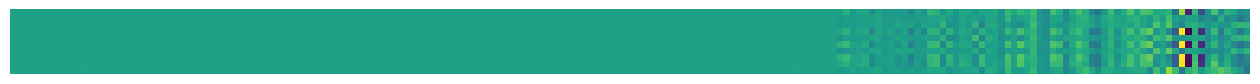

In [32]:
for head_id in tqdm(range(128)):
    plt.clf()
    q_to_viz=q[0,1:,head_id,:].detach().cpu().float().numpy()
    fig=plt.figure(0,(16,9))
    plt.imshow(q_to_viz)
    plt.axis('off')
    plt.savefig(save_dir+'/'+str(head_id)+'/q_1.png', dpi=150, transparent=True, bbox_inches='tight')

In [36]:
# q_to_viz.shape

In [33]:
q_nope, q_pe = torch.split(q, [mla.qk_nope_head_dim, mla.qk_rope_head_dim], dim=-1)

In [34]:
q_nope.shape, q_pe.shape #Cool yeah taking the last 64 columns for positional embedding -> dope. I wonder why 64 cols for positional embedding?

(torch.Size([1, 11, 128, 128]), torch.Size([1, 11, 128, 64]))

/tmp/ipykernel_21378/3281316253.py:4: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  fig=plt.figure(0,(16,9))
100%|████████████████████████████████████████████| 128/128 [00:07<00:00, 16.05it/s]


<Figure size 640x480 with 0 Axes>

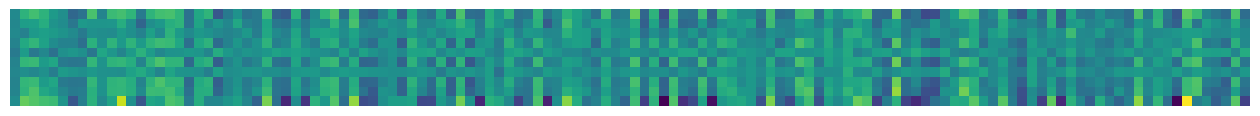

In [35]:
for head_id in tqdm(range(128)):
    plt.clf()
    q_to_viz=q_nope[0,1:,head_id,:].detach().cpu().float().numpy()
    fig=plt.figure(0,(16,9))
    plt.imshow(q_to_viz)
    plt.axis('off')
    plt.savefig(save_dir+'/'+str(head_id)+'/q_nope.png', dpi=150, transparent=True, bbox_inches='tight')

/tmp/ipykernel_21378/660577568.py:4: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  fig=plt.figure(0,(16,9))
100%|████████████████████████████████████████████| 128/128 [00:11<00:00, 11.26it/s]


<Figure size 640x480 with 0 Axes>

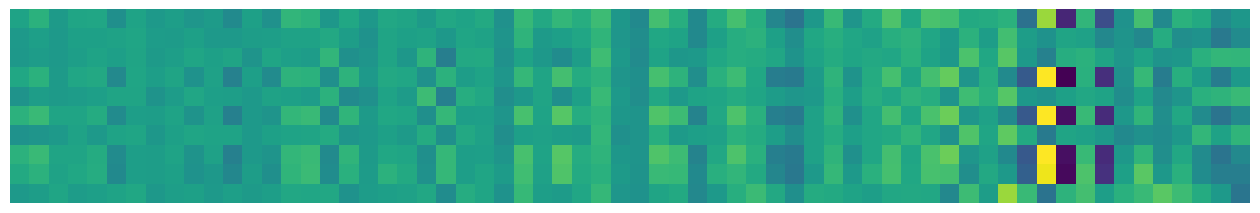

In [36]:
for head_id in tqdm(range(128)):
    plt.clf()
    q_to_viz=q_pe[0,1:,head_id,:].detach().cpu().float().numpy()
    fig=plt.figure(0,(16,9))
    plt.imshow(q_to_viz)
    plt.axis('off')
    plt.savefig(save_dir+'/'+str(head_id)+'/q_pe.png', dpi=150, transparent=True, bbox_inches='tight')

In [37]:
q_pe = apply_rotary_emb(q_pe, freqs_cis)

/tmp/ipykernel_21378/2217165185.py:4: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  fig=plt.figure(0,(16,9))
100%|████████████████████████████████████████████| 128/128 [00:11<00:00, 11.33it/s]


<Figure size 640x480 with 0 Axes>

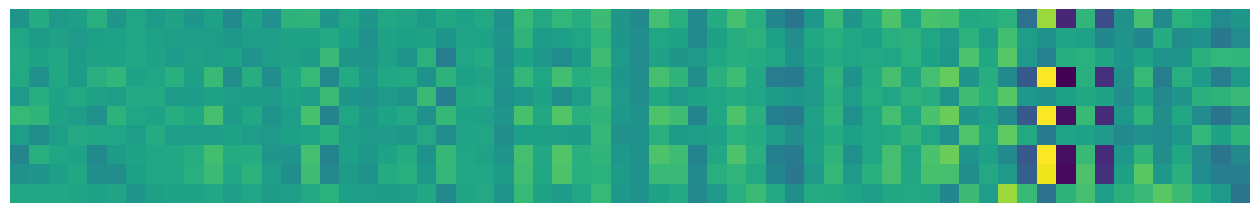

In [38]:
for head_id in tqdm(range(128)):
    plt.clf()
    q_to_viz=q_pe[0,1:,head_id,:].detach().cpu().float().numpy()
    fig=plt.figure(0,(16,9))
    plt.imshow(q_to_viz)
    plt.axis('off')
    plt.savefig(save_dir+'/'+str(head_id)+'/q_pe_after_embedding.png', dpi=150, transparent=True, bbox_inches='tight')

In [39]:
mla.wkv_a.weight.shape

torch.Size([576, 7168])

In [40]:
kv = mla.wkv_a(x)

In [41]:
kv.shape

torch.Size([1, 11, 576])

So, this is wild b/c it's for all the heads, and I'm pretty sure it doesn't just get like chopped back apart, ya know?

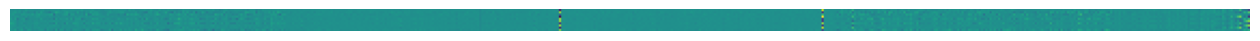

In [42]:
to_viz=kv[0,1:,:].detach().cpu().float().numpy()
fig=plt.figure(0,(16,9))
plt.imshow(to_viz)
plt.axis('off')
plt.savefig(save_dir+'/kv.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

Intersting skinteresting

In [43]:
kv, k_pe = torch.split(kv, [mla.kv_lora_rank, mla.qk_rope_head_dim], dim=-1)
k_pe = apply_rotary_emb(k_pe.unsqueeze(2), freqs_cis)

In [44]:
kv.shape, k_pe.shape

(torch.Size([1, 11, 512]), torch.Size([1, 11, 1, 64]))

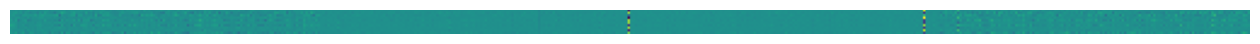

In [45]:
to_viz=kv[0,1:,:].detach().cpu().float().numpy()
fig=plt.figure(0,(16,9))
plt.imshow(to_viz)
plt.axis('off')
plt.savefig(save_dir+'/kv2.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

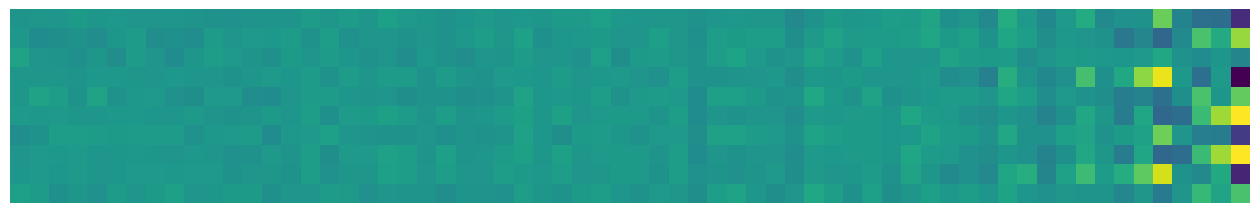

In [46]:
to_viz=k_pe[0,1:,0,:].detach().cpu().float().numpy()
fig=plt.figure(0,(16,9))
plt.imshow(to_viz)
plt.axis('off')
plt.savefig(save_dir+'/kpe.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

- Man visualizing this is helpful -> chopping off the end and adding positional embeddings
- It's kinda wild that positional embedding work -> they seem so manual
- ROPE could be a fun video - probably to narrow, but we'll see!

In [47]:
# freqs_cis.shape

In [48]:
# to_viz=freqs_cis.detach().cpu().numpy().real
# fig=plt.figure(0,(16,9))
# plt.imshow(to_viz)
# plt.axis('off')
# plt.savefig(save_dir+'/freqs_cis_real.png', dpi=150, transparent=True, bbox_inches='tight')
# plt.show()

In [49]:
# to_viz=freqs_cis.detach().cpu().numpy().imag
# fig=plt.figure(0,(16,9))
# plt.imshow(to_viz)
# plt.axis('off')
# plt.savefig(save_dir+'/freqs_cis_imag.png', dpi=150, transparent=True, bbox_inches='tight')
# plt.show()

In [47]:
wkv_b = mla.wkv_b.weight if mla.wkv_b.scale is None else weight_dequant(mla.wkv_b.weight, mla.wkv_b.scale, block_size) 
wkv_b = wkv_b.view(mla.n_local_heads, -1, mla.kv_lora_rank)
q_nope = torch.einsum("bshd,hdc->bshc", q_nope, wkv_b[:, :mla.qk_nope_head_dim]) 

In [59]:
q_nope.shape

torch.Size([1, 11, 128, 512])

/tmp/ipykernel_21378/3284403027.py:4: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  fig=plt.figure(0,(16,9))
100%|████████████████████████████████████████████| 128/128 [00:05<00:00, 25.56it/s]


<Figure size 640x480 with 0 Axes>

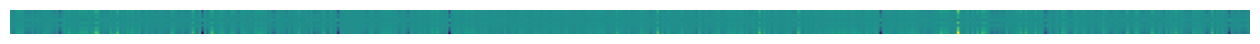

In [60]:
for head_id in tqdm(range(128)):
    plt.clf()
    q_to_viz=q_nope[0,1:,head_id,:].detach().cpu().float().numpy()
    fig=plt.figure(0,(16,9))
    plt.imshow(q_to_viz)
    plt.axis('off')
    plt.savefig(save_dir+'/'+str(head_id)+'/q_latent.png', dpi=150, transparent=True, bbox_inches='tight')

In [61]:
q_to_viz.shape

(10, 512)

In [48]:
mla.register_buffer("kv_cache", torch.zeros(args.max_batch_size, args.max_seq_len, mla.kv_lora_rank), persistent=False)
mla.register_buffer("pe_cache", torch.zeros(args.max_batch_size, args.max_seq_len, mla.qk_rope_head_dim), persistent=False)

In [50]:
mla.kv_cache[:bsz, start_pos:end_pos] = mla.kv_norm(kv)
mla.pe_cache[:bsz, start_pos:end_pos] = k_pe.squeeze(2)
scores = (torch.einsum("bshc,btc->bsht", q_nope.to(torch.bfloat16), mla.kv_cache[:bsz, :end_pos].to(torch.bfloat16)) +
          torch.einsum("bshr,btr->bsht", q_pe.to(torch.bfloat16), mla.pe_cache[:bsz, :end_pos].to(torch.bfloat16))) * mla.softmax_scale

In [79]:
# k_nope.shape

In [80]:
# v.shape

/tmp/ipykernel_21378/2855799875.py:4: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  fig=plt.figure(0,(16,9))
100%|████████████████████████████████████████████| 128/128 [00:20<00:00,  6.34it/s]


<Figure size 640x480 with 0 Axes>

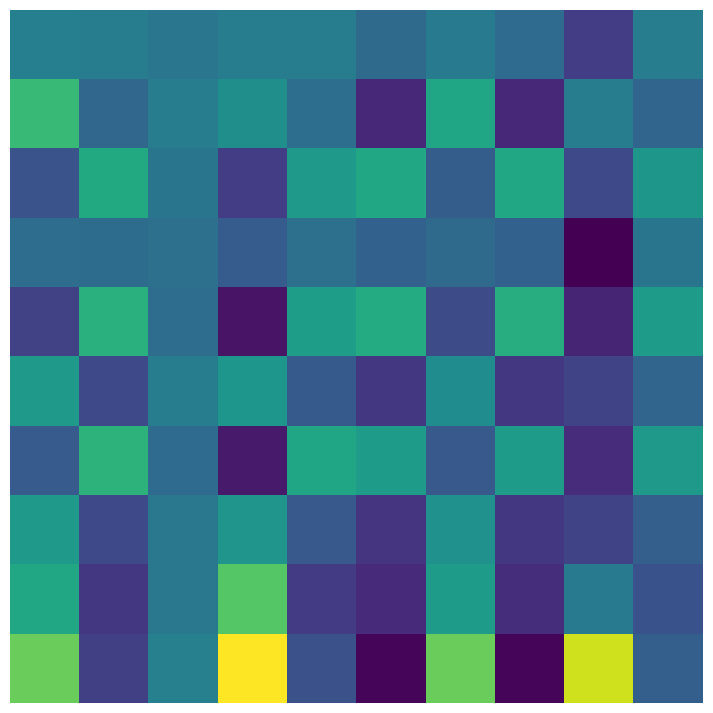

In [51]:
for head_id in tqdm(range(128)):
    plt.clf()
    to_viz=scores[0,1:,head_id,1:].detach().cpu().float().numpy()
    fig=plt.figure(0,(16,9))
    plt.imshow(to_viz)
    plt.axis('off')
    plt.savefig(save_dir+'/'+str(head_id)+'/scores_single_1.png', dpi=150, transparent=True, bbox_inches='tight')

In [52]:
if mask is not None:
    scores += mask.unsqueeze(1)

In [53]:
# to_viz=torch.clone(scores[0,:,0,:]).detach().cpu().float().numpy()
# fig=plt.figure(0,(4,4))
# plt.imshow(to_viz)
# plt.axis('off')
# plt.savefig(save_dir+'/scores_single_2.png', dpi=150, transparent=True, bbox_inches='tight')
# plt.show()

/tmp/ipykernel_21378/2591501854.py:6: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  fig=plt.figure(0,(6,6))
100%|████████████████████████████████████████████| 128/128 [00:10<00:00, 12.26it/s]


<Figure size 640x480 with 0 Axes>

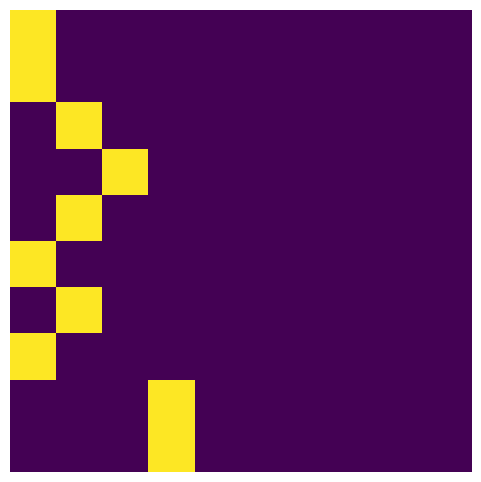

In [54]:
for head_id in tqdm(range(128)):
    plt.clf()
    to_viz=torch.clone(scores[0,1:,head_id,1:]).detach().cpu()
    to_viz=to_viz.softmax(dim=-1, dtype=torch.float32).type_as(x)
    to_viz=to_viz.float().numpy()
    fig=plt.figure(0,(6,6))
    plt.imshow(to_viz)
    plt.axis('off')
    plt.savefig(save_dir+'/'+str(head_id)+'/scores_single_3.png', dpi=150, transparent=True, bbox_inches='tight')

In [87]:
# torch.clone(scores[0,:,0,:].detach().cpu().float())/1e7

/tmp/ipykernel_21378/1320738958.py:16: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  fig=plt.figure(0,(6,6))
100%|████████████████████████████████████████████| 128/128 [00:09<00:00, 13.07it/s]


<Figure size 640x480 with 0 Axes>

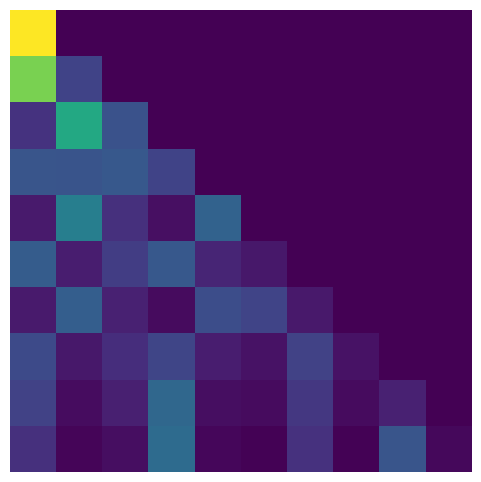

In [55]:
# to_viz=torch.clone(scores[0,:,0,:]).detach().cpu().float()/1e7
# to_viz=to_viz.softmax(dim=-1, dtype=torch.float32).type_as(x)
# to_viz=to_viz.float().numpy()

# fig=plt.figure(0,(4,4))
# plt.imshow(to_viz)
# plt.axis('off')
# plt.savefig(save_dir+'/scores_single_4.png', dpi=150, transparent=True, bbox_inches='tight')
# plt.show()

for head_id in tqdm(range(128)):
    plt.clf()
    to_viz=torch.clone(scores[0,1:,head_id,1:]).detach().cpu().float()/1e7
    to_viz=to_viz.softmax(dim=-1, dtype=torch.float32).type_as(x)
    to_viz=to_viz.float().numpy()
    fig=plt.figure(0,(6,6))
    plt.imshow(to_viz)
    plt.axis('off')
    plt.savefig(save_dir+'/'+str(head_id)+'/scores_single_4.png', dpi=150, transparent=True, bbox_inches='tight')

/tmp/ipykernel_21378/538405831.py:6: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  fig=plt.figure(0,(6,6))
100%|████████████████████████████████████████████| 128/128 [00:09<00:00, 13.03it/s]


<Figure size 640x480 with 0 Axes>

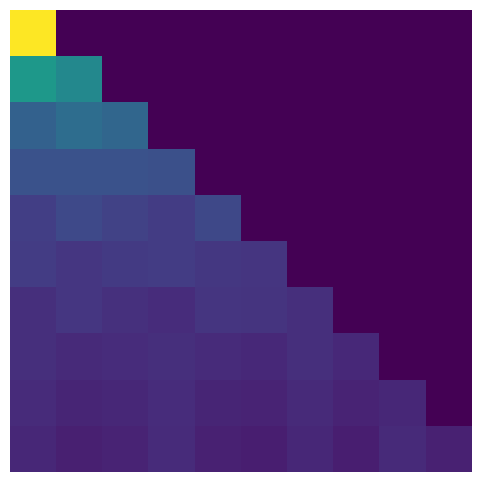

In [56]:
for head_id in tqdm(range(128)):
    plt.clf()
    to_viz=torch.clone(scores[0,1:,head_id,1:]).detach().cpu().float()/1e8
    to_viz=to_viz.softmax(dim=-1, dtype=torch.float32).type_as(x)
    to_viz=to_viz.float().numpy()
    fig=plt.figure(0,(6,6))
    plt.imshow(to_viz)
    plt.axis('off')
    plt.savefig(save_dir+'/'+str(head_id)+'/scores_single_5.png', dpi=150, transparent=True, bbox_inches='tight')

In [57]:
scores = scores.softmax(dim=-1, dtype=torch.float32).type_as(x)

In [58]:
# sf

In [93]:
# to_viz=scores[0].detach().cpu().float().numpy()
# fig=plt.figure(0,(16,16))
# for i in range(128):
#     ax=fig.add_subplot(12, 12, i+1)
#     ax.imshow(to_viz[:,i,:])
#     plt.axis('off')
# plt.savefig(save_dir+'/scores_3.png', dpi=150, transparent=True, bbox_inches='tight')
# plt.show()

In [62]:
x = torch.einsum("bsht,btc->bshc", scores, mla.kv_cache[:bsz, :end_pos])

In [63]:
x.shape

torch.Size([1, 11, 128, 512])

/tmp/ipykernel_21378/2349946526.py:4: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  fig=plt.figure(0,(16,9))
100%|████████████████████████████████████████████| 128/128 [00:05<00:00, 23.23it/s]


<Figure size 640x480 with 0 Axes>

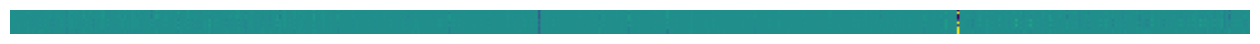

In [64]:
for head_id in tqdm(range(128)):
    plt.clf()
    q_to_viz=x[0,1:,head_id,:].detach().cpu().float().numpy()
    fig=plt.figure(0,(16,9))
    plt.imshow(q_to_viz)
    plt.axis('off')
    plt.savefig(save_dir+'/'+str(head_id)+'/alkv.png', dpi=150, transparent=True, bbox_inches='tight')

In [66]:
x = torch.einsum("bshc,hdc->bshd", x.to(torch.bfloat16), wkv_b[:, -mla.v_head_dim:].to(torch.bfloat16))

In [67]:
x.shape

torch.Size([1, 11, 128, 128])

/tmp/ipykernel_21378/1000951977.py:4: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  fig=plt.figure(0,(16,9))
100%|████████████████████████████████████████████| 128/128 [00:07<00:00, 16.86it/s]


<Figure size 640x480 with 0 Axes>

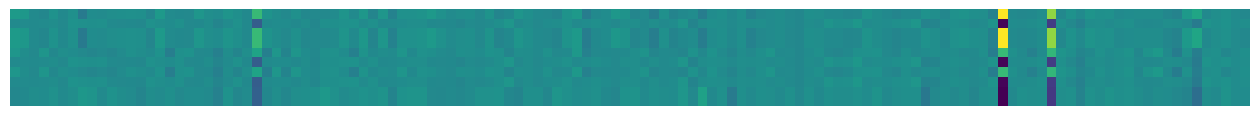

In [68]:
for head_id in tqdm(range(128)):
    plt.clf()
    to_viz=x[0,1:,head_id,:].detach().cpu().float().numpy()
    fig=plt.figure(0,(16,9))
    plt.imshow(to_viz)
    plt.axis('off')
    plt.savefig(save_dir+'/'+str(head_id)+'/x_1.png', dpi=150, transparent=True, bbox_inches='tight')

In [71]:
 x = mla.wo(x.flatten(2))

In [72]:
x.shape

torch.Size([1, 11, 7168])

--

In [291]:
# scores.shape

In [88]:
mla.kv_cache[:bsz, :end_pos].shape #This is the same slice we used before -> mla.kv_cache[:bsz, :end_pos]

torch.Size([1, 11, 512])

In [89]:
scores.shape

torch.Size([1, 11, 128, 11])

In [90]:
x_tmp=[]
for head_num in range(128):
    x_tmp.append(scores[0, :, head_num, :].detach() @ mla.kv_cache[:bsz, :end_pos][0].detach())
x_tmp=torch.stack(x_tmp, dim=1).unsqueeze(0)

In [91]:
x_tmp.shape

torch.Size([1, 11, 128, 512])

In [92]:
x = torch.einsum("bsht,btc->bshc", scores, mla.kv_cache[:bsz, :end_pos]) # On that's intresting - just the cache and attention pattern here.

In [93]:
x.shape

torch.Size([1, 11, 128, 512])

In [94]:
torch.testing.assert_close(x, x_tmp)

- Ok yeah this makes sense, just crazy to me that we're able to use the same kv cache!
- Woah that pattern is kinda interesting - some very strong lines

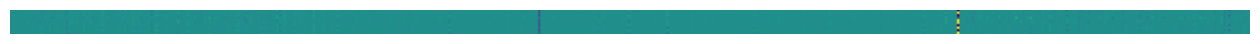

In [321]:
head_id=0
to_viz=x[0,:,head_id,:].detach().cpu().float().numpy()
fig=plt.figure(0,(16,9))
plt.imshow(to_viz)
plt.axis('off')
plt.savefig(save_dir+'/x_1.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

- Woah the other half of the wkv_b matrix? What the hell is happening? This cannot be more computationally efficient right?
- I'm confused.
- Last time was `wkv_b[:, :mla.qk_nope_head_dim]`
- Does it matter that it's 2 halves of the samt matrix?

In [322]:
x.shape

torch.Size([1, 10, 128, 512])

In [323]:
wkv_b[:, -mla.v_head_dim:].shape

torch.Size([128, 128, 512])

In [329]:
x_tmp_2=torch.clone(x.detach())
x_tmp_3=[]
for head_num in range(128):
    x_tmp_3.append(x_tmp_2[0, :, head_num, :].to(torch.bfloat16) @ wkv_b[:, -mla.v_head_dim:][head_num].T)
x_tmp_3=torch.stack(x_tmp_3,dim=1).unsqueeze(0)

In [330]:
x_tmp_3.shape

torch.Size([1, 10, 128, 128])

In [331]:
x = torch.einsum("bshc,hdc->bshd", x.to(torch.bfloat16), wkv_b[:, -mla.v_head_dim:]) #Not sure what this one is doing exactly...

In [332]:
x.shape

torch.Size([1, 10, 128, 128])

In [333]:
torch.testing.assert_close(x, x_tmp_3)

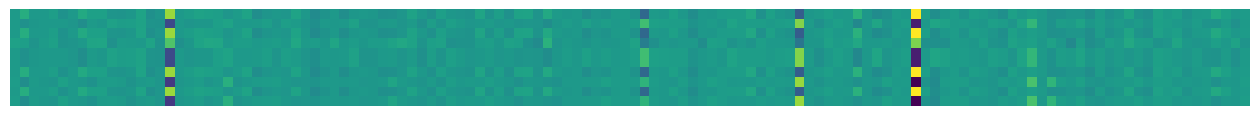

In [334]:
head_id=0
to_viz=x[0,:,head_id,:].detach().cpu().float().numpy()
fig=plt.figure(0,(16,9))
plt.imshow(to_viz)
plt.axis('off')
plt.savefig(save_dir+'/x_2.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

again kinda interesring pattern

In [313]:
x = mla.wo(x.flatten(2))

In [314]:
x.shape

torch.Size([1, 10, 7168])

Ok getting warmer but still confused - feels like more computation than naive!

In [315]:
torch.testing.assert_close(x, h_out_reference) #dopety ropety. 

In [38]:
x.shape, h_out_reference.shape

(torch.Size([1, 10, 7168]), torch.Size([1, 10, 7168]))

In [39]:
x

tensor([[[ 880640., -466944.,  765952.,  ..., -573440., -119296., -456704.],
         [1843200.,  319488.,  774144.,  ...,   88576., -663552., -417792.],
         [1155072.,   36864.,  234496.,  ...,  737280., -892928., -108544.],
         ...,
         [1171456.,   91648.,  468992.,  ...,  729088.,  667648., -152576.],
         [ 142336., -978944., -235520.,  ..., 1376256.,   40192.,  847872.],
         [ 614400.,  374784.,  548864.,  ..., 2097152., -370688.,  454656.]]],
       dtype=torch.bfloat16, grad_fn=<UnsafeViewBackward0>)

In [40]:
h_out_reference

tensor([[[ 880640., -466944.,  765952.,  ..., -573440., -119296., -456704.],
         [1843200.,  319488.,  774144.,  ...,   88576., -663552., -417792.],
         [1155072.,   36864.,  234496.,  ...,  737280., -892928., -108544.],
         ...,
         [1171456.,   91648.,  468992.,  ...,  729088.,  667648., -152576.],
         [ 142336., -978944., -235520.,  ..., 1376256.,   40192.,  847872.],
         [ 614400.,  374784.,  548864.,  ..., 2097152., -370688.,  454656.]]],
       dtype=torch.bfloat16, grad_fn=<UnsafeViewBackward0>)